## Anomaly Detection
### Laboratory 5

### Ex. 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.random.multivariate_normal([5, 10, 2], [[3, 2, 2], [2, 10, 1], [2, 1, 2]], 500)

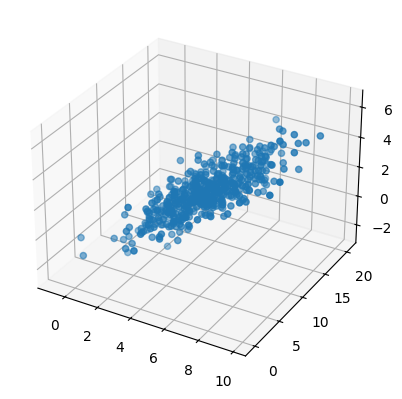

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2])

plt.show()

In [4]:
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean
cov_matrix = np.cov(X_centered, rowvar=False)

cov_matrix

array([[ 2.81754814,  1.93907135,  1.89570441],
       [ 1.93907135, 10.41327255,  1.2083633 ],
       [ 1.89570441,  1.2083633 ,  1.98942764]])

In [5]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

In [6]:
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

In [7]:
cumvar = np.cumsum(eigenvalues)

cumvar

array([11.17359266, 14.76590591, 15.22024833])

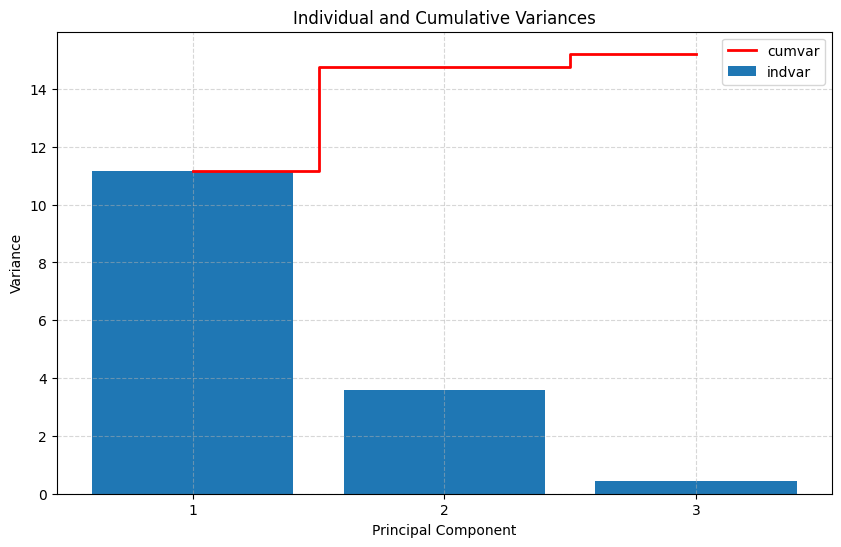

In [8]:
plt.figure(figsize=(10, 6))
components = np.arange(1, len(eigenvalues) + 1)

plt.bar(
    components,
    eigenvalues,
    label="indvar",
)

plt.step(
    components,
    cumvar,
    where="mid",
    label="cumvar",
    color='r',
    linewidth=2,
)

plt.xlabel("Principal Component")
plt.ylabel("Variance")
plt.title("Individual and Cumulative Variances")
plt.xticks(components)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [9]:
X_projected = np.dot(X_centered, eigenvectors)
X_projected

array([[ 0.24088207,  2.21413834, -0.3582986 ],
       [ 0.63067987, -2.77049819,  0.18423735],
       [ 0.75767731, -1.15109636, -1.49432946],
       ...,
       [ 1.75232257, -1.89870313, -0.3242705 ],
       [ 0.71795153, -2.65226127, -0.30772626],
       [ 3.37313359, -0.10121387, -0.19989895]], shape=(500, 3))

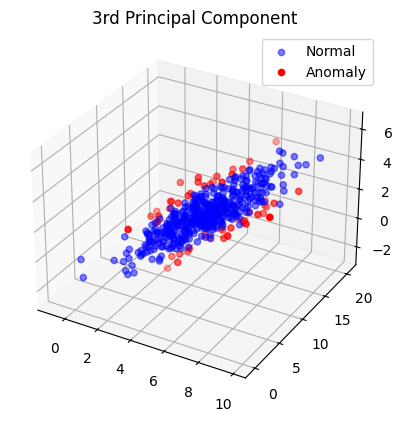

In [10]:
contamination_rate = 0.1

pc3_values = X_projected[:, 2]
pc3_deviations = np.abs(pc3_values - np.mean(pc3_values))
threshold_pc3 = np.quantile(pc3_deviations, 1 - contamination_rate)
labels_pc3 = pc3_deviations > threshold_pc3

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X[~labels_pc3, 0],
    X[~labels_pc3, 1],
    X[~labels_pc3, 2],
    c="b",
    label="Normal",
    alpha=0.5,
)

ax.scatter(
    X[labels_pc3, 0], X[labels_pc3, 1], X[labels_pc3, 2], c="r", label="Anomaly"
)

ax.set_title("3rd Principal Component")
ax.legend()
plt.show()

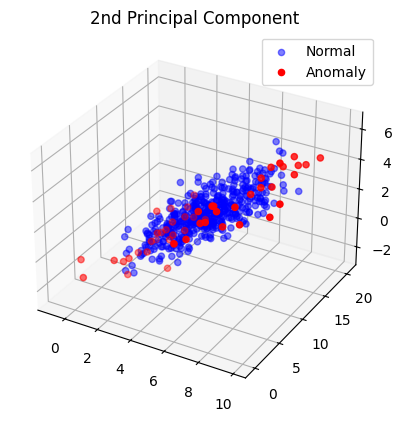

In [11]:
contamination_rate = 0.1

pc3_values = X_projected[:, 1]
pc3_deviations = np.abs(pc3_values - np.mean(pc3_values))
threshold_pc3 = np.quantile(pc3_deviations, 1 - contamination_rate)
labels_pc3 = pc3_deviations > threshold_pc3

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X[~labels_pc3, 0],
    X[~labels_pc3, 1],
    X[~labels_pc3, 2],
    c="b",
    label="Normal",
    alpha=0.5,
)

ax.scatter(X[labels_pc3, 0], X[labels_pc3, 1], X[labels_pc3, 2], c="r", label="Anomaly")

ax.set_title("2nd Principal Component")
ax.legend()
plt.show()

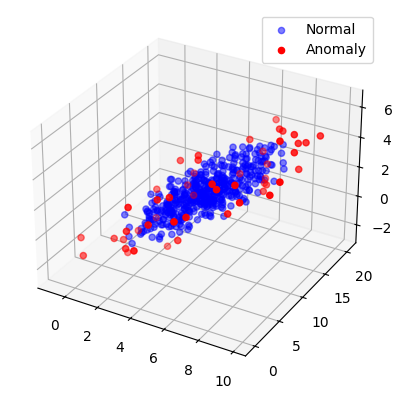

In [12]:
std_devs = np.sqrt(eigenvalues)
X_normalized = X_projected / std_devs
distances = np.linalg.norm(X_normalized, axis=1)
threshold_dist = np.quantile(distances, 1 - contamination_rate)
labels_dist = distances > threshold_dist

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X[~labels_dist, 0],
    X[~labels_dist, 1],
    X[~labels_dist, 2],
    c="b",
    label="Normal",
    alpha=0.5,
)
ax.scatter(
    X[labels_dist, 0],
    X[labels_dist, 1],
    X[labels_dist, 2],
    c="r",
    label="Anomaly",
)

ax.legend()
plt.show()

### Ex. 2

In [13]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
data = loadmat("data/shuttle.mat")
X = data["X"]
y = data["y"].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, random_state=42, shuffle=True
)

In [15]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [16]:
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA

In [17]:
clf_pca = PCA()
clf_pca.fit(X_train_norm)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [18]:
explained_variance = clf_pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

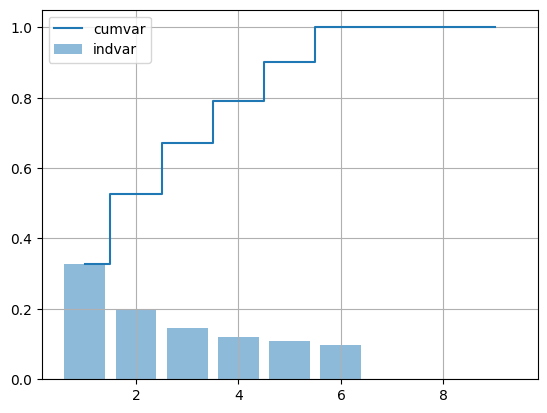

In [19]:
plt.figure()
plt.bar(
    range(1, len(explained_variance) + 1),
    explained_variance,
    alpha=0.5,
    align="center",
    label="indvar",
)
plt.step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where="mid",
    label="cumvar",
)
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import balanced_accuracy_score

In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    b_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    b_acc_test = balanced_accuracy_score(y_test, y_test_pred)

    print(f"{model_name}:")
    print(f"Balanced Accuracy (Train): {b_acc_train:.4f}")
    print(f"Balanced Accuracy (Test):  {b_acc_test:.4f}")

In [22]:
evaluate_model(clf_pca, X_train_norm, y_train, X_test_norm, y_test, model_name="PCA")

PCA:
Balanced Accuracy (Train): 0.9644
Balanced Accuracy (Test):  0.9649


In [23]:
sample_size = int(len(X_train_norm) * 0.1)

random_indices = np.random.choice(len(X_train_norm), size=sample_size, replace=False)
X_train_sample = X_train_norm[random_indices]

# 10% of the data because the model wouldn't fit...
clf_kpca = KPCA()
clf_kpca.fit(X_train_sample)

KPCA(alpha=1.0, coef0=1, contamination=0.1, copy_X=True, degree=3,
   eigen_solver='auto', gamma=None, kernel='rbf', kernel_params=None,
   max_iter=None, n_components=None, n_jobs=None,
   n_selected_components=None,
   random_state=RandomState(MT19937) at 0x7E990D9CB140,
   remove_zero_eig=False, sampling=False, subset_size=20, tol=0)

In [24]:
evaluate_model(clf_kpca, X_train_norm, y_train, X_test_norm, y_test, model_name="KPCA")

KPCA:
Balanced Accuracy (Train): 0.7003
Balanced Accuracy (Test):  0.7164


### Ex. 3

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler

2025-12-15 21:58:16.647709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
data = loadmat("data/shuttle.mat")
X = data["X"]
y = data["y"].ravel()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

In [28]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
class Autoencoder(keras.Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        self.encoder = keras.Sequential(
            [
                layers.Dense(8, activation="relu", input_shape=(input_dim,)),
                layers.Dense(5, activation="relu"),
                layers.Dense(3, activation="relu"),
            ]
        )

        self.decoder = keras.Sequential(
            [
                layers.Dense(5, activation="relu", input_shape=(3,)),
                layers.Dense(8, activation="relu"),
                layers.Dense(9, activation="sigmoid")
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [30]:
input_dim = X_train_scaled.shape[1]
autoencoder = Autoencoder(input_dim)

/home/s1rbu/miniconda3/envs/anomaly-detection/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765828719.192987   13791 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5508 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [31]:
autoencoder.compile(optimizer="adam", loss="mse")

In [32]:
history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=100,
    batch_size=1024,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=0
)

2025-12-15 22:42:03.251205: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e974c004c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 22:42:03.251224: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-15 22:42:03.301295: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 22:42:03.691258: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1765831329.743789   14496 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-15 22:42:11.589162: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

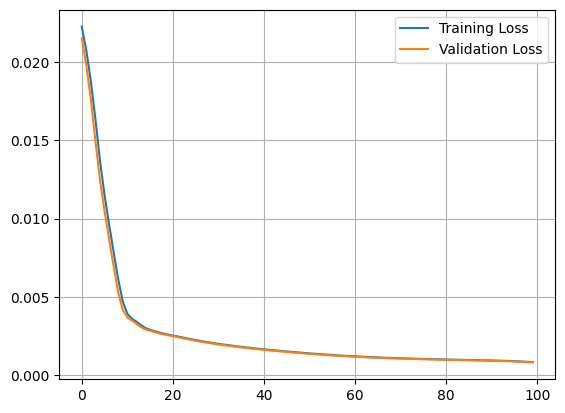

In [33]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def get_predictions(model, data, threshold):
    reconstructions = model.predict(data)
    loss = np.mean(np.power(data - reconstructions, 2), axis=1)
    return (loss > threshold).astype(int), loss

In [35]:
contamination_rate = np.sum(y_train == 1) / len(y_train)
contamination_rate

np.float64(0.07214437021345935)

In [36]:
_, train_loss = get_predictions(autoencoder, X_train_scaled, threshold=0)

768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [37]:
threshold = np.quantile(train_loss, 1 - contamination_rate)
threshold

np.float64(0.00213593445939926)

In [38]:
y_train_pred, _ = get_predictions(autoencoder, X_train_scaled, threshold)
b_acc_train = balanced_accuracy_score(y_train, y_train_pred)

768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step


In [39]:
y_test_pred, _ = get_predictions(autoencoder, X_test_scaled, threshold)
b_acc_test = balanced_accuracy_score(y_test, y_test_pred)

768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [40]:
print(b_acc_train)
print(b_acc_test)

0.6564697559751685
0.6549583044200641


### Ex. 4

In [41]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [42]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [43]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [44]:
def add_noise(images):
    noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0)
    noisy_images = images + 0.35 * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

In [45]:
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [47]:
from tensorflow.keras import models

In [48]:
class ConvolutionalAutoencoder(models.Model):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()

        self.encoder = models.Sequential(
            [
                layers.Input(shape=(28, 28, 1)),
                layers.Conv2D(8, (3, 3), activation="relu", strides=2, padding="same"),
                layers.Conv2D(4, (3, 3), activation="relu", strides=2, padding="same"),
            ]
        )

        self.decoder = models.Sequential(
            [
                layers.Conv2DTranspose(4, (3, 3), activation="relu", strides=2, padding="same"),
                layers.Conv2DTranspose(8, (3, 3), activation="relu", strides=2, padding="same"),
                layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [50]:
autoencoder = ConvolutionalAutoencoder()
autoencoder.compile(optimizer="adam", loss="mse")

In [51]:
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=1,
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0301 - val_loss: 0.0060
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - val_loss: 0.0035


In [52]:
reconstructions_train = autoencoder.predict(x_train)
train_loss = tf.keras.losses.mse(reconstructions_train, x_train)
train_loss = tf.reduce_mean(train_loss, axis=(1, 2))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [53]:
threshold = np.mean(train_loss) + np.std(train_loss)
threshold

np.float32(0.0055225296)

In [54]:
rec_test_clean = autoencoder.predict(x_test)
loss_clean = tf.reduce_mean(tf.keras.losses.mse(rec_test_clean, x_test), axis=(1, 2))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [55]:
rec_test_noisy = autoencoder.predict(x_test_noisy)
loss_noisy = tf.reduce_mean(
    tf.keras.losses.mse(rec_test_noisy, x_test_noisy), axis=(1, 2)
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [56]:
correct_clean = np.sum(loss_clean <= threshold)
correct_noisy = np.sum(loss_noisy > threshold)

In [57]:
total_samples = len(x_test) * 2
accuracy = (correct_clean + correct_noisy) / total_samples

accuracy

np.float64(0.9422)

In [64]:
def plot_results(model, x_clean, x_noisy):
    n = 5
    plt.figure()

    decoded_clean = model.predict(x_clean[:n])
    decoded_noisy = model.predict(x_noisy[:n])

    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(tf.squeeze(x_clean[i]), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(tf.squeeze(x_noisy[i]), cmap="gray")
        plt.title("Noisy")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(tf.squeeze(decoded_clean[i]), cmap="gray")
        plt.title("Rec. (Orig)")
        plt.axis("off")

        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(tf.squeeze(decoded_noisy[i]), cmap="gray")
        plt.title("Rec. (Noisy)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


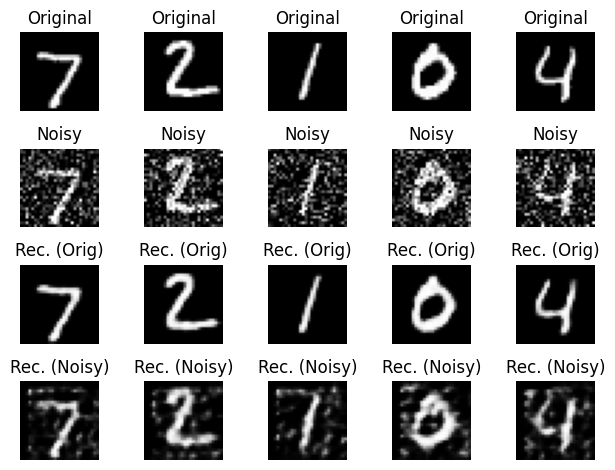

In [65]:
plot_results(autoencoder, x_test, x_test_noisy)

In [62]:
denoising_ae = ConvolutionalAutoencoder()
denoising_ae.compile(optimizer="adam", loss="mse")

denoising_ae.fit(
    x_train_noisy,
    x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    verbose=1,
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1189 - val_loss: 0.1140
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1120 - val_loss: 0.1140


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


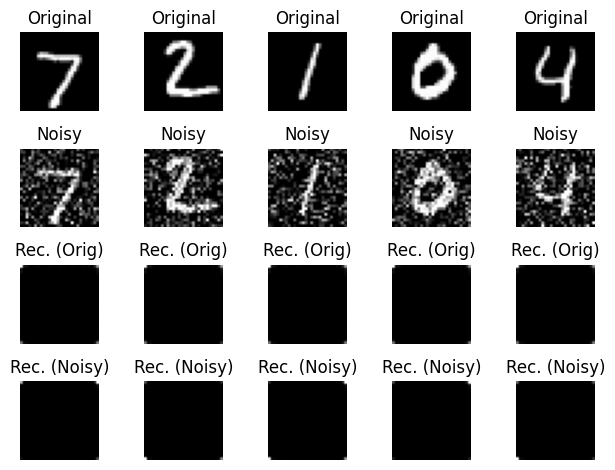

In [66]:
plot_results(denoising_ae, x_test, x_test_noisy)